## Tape bump assessment (py3). CCD 01
Remember the tape bump is temperature-variation dependent

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize, ZScaleInterval)
%matplotlib notebook

Load the data from basic statistics time series. For *tapebump\_centeright_{band}.npy* files, the statistic was extracted from Y4A1 tag, from 20161013 to 20161101


In [2]:
g_stat = np.load('tapebump_centeright_y4a1_g.npy')
r_stat = np.load('tapebump_centeright_y4a1_r.npy')
i_stat = np.load('tapebump_centeright_y4a1_i.npy')
z_stat = np.load('tapebump_centeright_y4a1_z.npy')
Y_stat = np.load('tapebump_centeright_y4a1_Y.npy')

Which fields do the simple stats has?

In [3]:
g_stat.dtype

dtype([('mean', '<f8'), ('median', '<f8'), ('std', '<f8'), ('min', '<i8'), ('max', '<i8'), ('mad', '<f8'), ('rms', '<f8'), ('nite', '<i8'), ('expnum', '<i8'), ('exptime', '<i8'), ('band', 'S10'), ('mjd', '<f8')])

Quick plots for assessment of time periods when the tapebump appears in the image. Then, visualize some of these in a movie-like plotting

In [4]:
days = [np.ptp(x['mjd']) for x in [g_stat, r_stat, i_stat, z_stat, Y_stat]] 

<IPython.core.display.Javascript object>


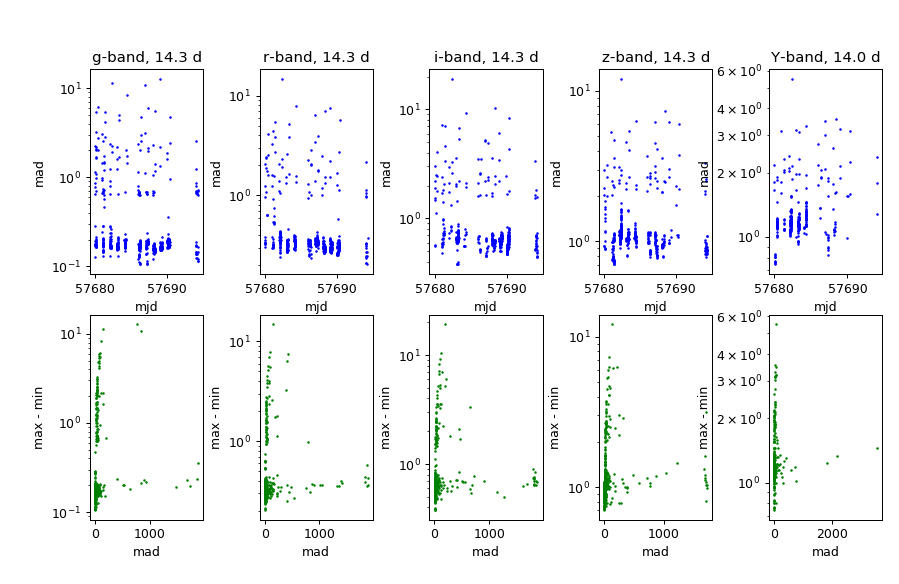

In [60]:
var_y1 = 'mad'
kw1 = {
    's' : 1, 
    'color' : 'blue',
}
fig, ax = plt.subplots(2, 5, figsize=(10, 6.5))
ax[0, 0].scatter(g_stat['mjd'], g_stat[var_y1], **kw1)
ax[0, 1].scatter(r_stat['mjd'], r_stat[var_y1], **kw1)
ax[0, 2].scatter(i_stat['mjd'], i_stat[var_y1], **kw1)
ax[0, 3].scatter(z_stat['mjd'], z_stat[var_y1], **kw1)
ax[0, 4].scatter(Y_stat['mjd'], Y_stat[var_y1], **kw1)
#
kw2 = {
    's' : 1,
    'color' : 'green',
}
ax[1, 0].scatter(g_stat['max'] - g_stat['min'], g_stat['mad'], **kw2)
ax[1, 1].scatter(r_stat['max'] - r_stat['min'], r_stat['mad'], **kw2)
ax[1, 2].scatter(i_stat['max'] - i_stat['min'], i_stat['mad'], **kw2)
ax[1, 3].scatter(z_stat['max'] - z_stat['min'], z_stat['mad'], **kw2)
ax[1, 4].scatter(Y_stat['max'] - Y_stat['min'], Y_stat['mad'], **kw2)
#
bands = ['g', 'r', 'i', 'z', 'Y']
for idx, s in enumerate(ax[0, :]):
    s.set_yscale('log')
    s.set_xlabel('mjd')
    s.set_ylabel('mad')
    s.set_title('{0}-band, {1:.1f} d'.format(bands[idx], days[idx]))
for idx, s in enumerate(ax[1, :]):
    s.set_yscale('log')
    s.set_xlabel('mad')
    s.set_ylabel('max - min')
#    
plt.subplots_adjust(wspace=0.5, left=0.1, right=0.98)

Let's start by g-band, using astropy for imashow color scaling. 

In [6]:
sel_g = g_stat[np.where(np.logical_and((g_stat['max'] - g_stat['min']) > 50, g_stat['mad'] > 0.4))]
# works too: [np.where(g_stat['mean'] < 0.4)]
# [np.where(g_stat['mad'] > 0.4)]
# [np.where(g_stat['min'] < -2)]
# [np.where(np.logical_and((g_stat['max'] - g_stat['min']) > 50, g_stat['mean'] < 0))]
sel_g_path = ['stamps/tape_centeright-y4a1_g_D00{0}.npy'.format(e) for e in sel_g['expnum']]

r-band

In [7]:
sel_r = r_stat[np.where(np.logical_and((r_stat['max'] - r_stat['min']) > 50, r_stat['mad'] > 0.4))]
sel_r_path = ['stamps/tape_centeright-y4a1_r_D00{0}.npy'.format(e) for e in sel_r['expnum']]

i-band

In [8]:
sel_i = i_stat[np.where(np.logical_and((i_stat['max'] - i_stat['min']) > 50, i_stat['mad'] > 0.4))]
sel_i_path = ['stamps/tape_centeright-y4a1_i_D00{0}.npy'.format(e) for e in sel_i['expnum']]

z-band

In [9]:
sel_z = z_stat[np.where(np.logical_and((z_stat['max'] - z_stat['min']) > 50, z_stat['mad'] > 0.4))]
sel_z_path = ['stamps/tape_centeright-y4a1_z_D00{0}.npy'.format(e) for e in sel_z['expnum']]

Y-band

In [10]:
sel_Y = Y_stat[np.where(np.logical_and((Y_stat['max'] - Y_stat['min']) > 20, Y_stat['mad'] > 0.4))]
sel_Y_path = ['stamps/tape_centeright-y4a1_Y_D00{0}.npy'.format(e) for e in sel_Y['expnum']]

In [11]:
print('Number of selected per band: g={0}, r={1}, z={2}, Y={3}'.format(sel_g.size, 
                                                                       sel_r.size, 
                                                                       sel_i.size,
                                                                       sel_z.size,
                                                                       sel_Y.size))

Number of selected per band: g=21, r=24, z=92, Y=77


Set animated plots 

In [18]:
def visual_sequence(path_list, anim_interval=200, anim_repeat=False, anim_save=False, outfnm=None):
    ''' Function to receive a list of full paths to files to be 
    displayed in order, in overlapping sequence.
    '''
    fig = plt.figure()
    ims = []
    for i in path_list:
        aux_x = np.load(i)
        # Normalize image, using astropy zscale for range, and square root for 
        # stretching (?)
        im_norm = ImageNormalize(aux_x, 
                                 interval=ZScaleInterval(),
                                 stretch=SqrtStretch())
        # Append each of the plots to a list
        kw  = {
            'origin' : 'lower', 
            'animated' : True, 
            'cmap' : 'gray_r',
        }
        im = plt.imshow(aux_x, norm=im_norm, **kw)
        ims.append([im])
    # Using the plot-populated list, create the animation
    # blitting (True/False) useful when the frame can be slightly modified to 
    # create the next frame
    ani = animation.ArtistAnimation(fig, ims, 
                                    interval=anim_interval, 
                                    blit=True,
                                    repeat_delay=1000, 
                                    repeat=anim_repeat)
    if anim_save:
        if (outfnm is None):
            outfnm = 'pid{0}.mp4'.format(os.getpid())
        # Set up formatting for the movie files
        aux_wr1 = animation.writers['ffmpeg']
        aux_writer = aux_wr1(fps=15, metadata=dict(artist='F Paz-Chinchon'), bitrate=2000, dpi=300)
        ani.save(outfnm, writer=aux_writer)
    else:
        plt.show()

<IPython.core.display.Javascript object>


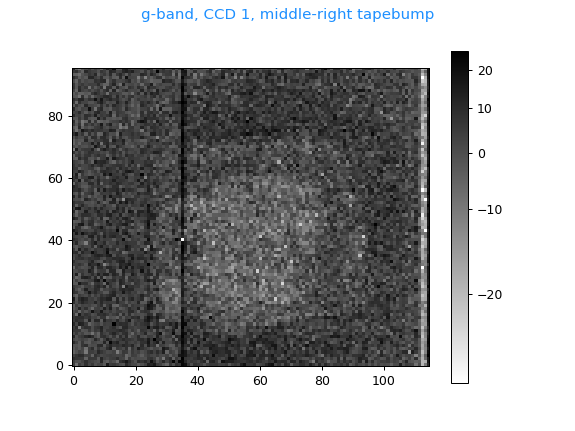

/Users/fco/anaconda3/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/fco/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


In [49]:
path_list = sel_g_path
anim_interval = 200
anim_repeat = False
anim_save = True
outfnm = 'g_tapebump_c01.mp4'
#
fig = plt.figure()
ims = []
for i in path_list:
    aux_x = np.load(i)
    # Normalize image, using astropy zscale for range, and square root for 
    # stretching (?)
    im_norm = ImageNormalize(aux_x, 
                             interval=ZScaleInterval(),
                             stretch=SqrtStretch())
    # Append each of the plots to a list
    kw  = {
        'origin' : 'lower', 
        'animated' : True, 
        'cmap' : 'gray_r',
    }
    im = plt.imshow(aux_x, norm=im_norm, **kw)
    ims.append([im])
# Using the plot-populated list, create the animation
# blitting (True/False) useful when the frame can be slightly modified to 
# create the next frame
ani = animation.ArtistAnimation(fig, ims, 
                                interval=anim_interval, 
                                blit=True,
                                repeat_delay=1000, 
                                repeat=anim_repeat)
plt.colorbar()
plt.suptitle('g-band, CCD 1, middle-right tapebump', color='dodgerblue')
if anim_save:
    if (outfnm is None):
        outfnm = 'pid{0}.mp4'.format(os.getpid())
    # Set up formatting for the movie files
    aux_wr1 = animation.writers['ffmpeg']
    aux_writer = aux_wr1(fps=5, metadata=dict(artist='F Paz-Chinchon'), bitrate=2000)
    ani.save(outfnm, writer=aux_writer)
    # plt.show()
else:
    plt.show()

<IPython.core.display.Javascript object>


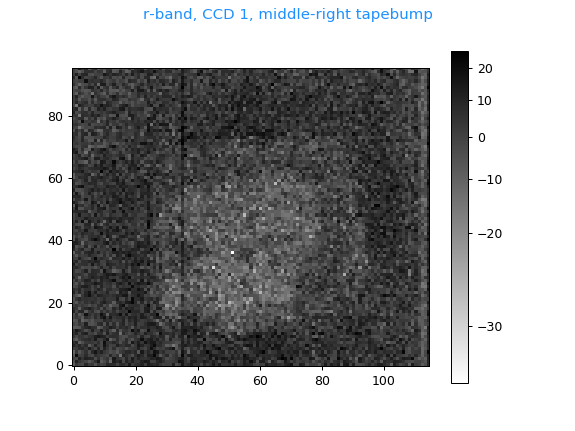

/Users/fco/anaconda3/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/fco/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


In [50]:
path_list = sel_r_path
anim_interval = 200
anim_repeat = False
anim_save = True
outfnm = 'r_tapebump_c01.mp4'
#
fig = plt.figure()
ims = []
for i in path_list:
    aux_x = np.load(i)
    # Normalize image, using astropy zscale for range, and square root for 
    # stretching (?)
    im_norm = ImageNormalize(aux_x, 
                             interval=ZScaleInterval(),
                             stretch=SqrtStretch())
    # Append each of the plots to a list
    kw  = {
        'origin' : 'lower', 
        'animated' : True, 
        'cmap' : 'gray_r',
    }
    im = plt.imshow(aux_x, norm=im_norm, **kw)
    ims.append([im])
# Using the plot-populated list, create the animation
# blitting (True/False) useful when the frame can be slightly modified to 
# create the next frame
ani = animation.ArtistAnimation(fig, ims, 
                                interval=anim_interval, 
                                blit=True,
                                repeat_delay=1000, 
                                repeat=anim_repeat)
plt.suptitle('r-band, CCD 1, middle-right tapebump', color='dodgerblue')
plt.colorbar()
if anim_save:
    if (outfnm is None):
        outfnm = 'pid{0}.mp4'.format(os.getpid())
    # Set up formatting for the movie files
    aux_wr1 = animation.writers['ffmpeg']
    aux_writer = aux_wr1(fps=5, metadata=dict(artist='F Paz-Chinchon'), bitrate=2000)
    ani.save(outfnm, writer=aux_writer)
    # plt.show()
else:
    plt.show()

<IPython.core.display.Javascript object>


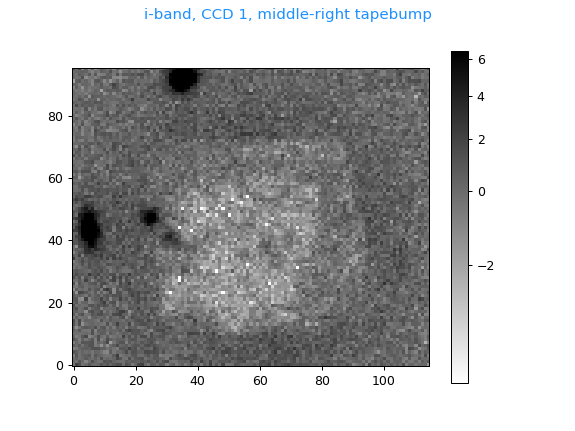

/Users/fco/anaconda3/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/fco/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


In [51]:
path_list = sel_i_path
anim_interval = 200
anim_repeat = False
anim_save = True
outfnm = 'i_tapebump_c01.mp4'
#
fig = plt.figure()
ims = []
for i in path_list:
    aux_x = np.load(i)
    # Normalize image, using astropy zscale for range, and square root for 
    # stretching (?)
    im_norm = ImageNormalize(aux_x, 
                             interval=ZScaleInterval(),
                             stretch=SqrtStretch())
    # Append each of the plots to a list
    kw  = {
        'origin' : 'lower', 
        'animated' : True, 
        'cmap' : 'gray_r',
    }
    im = plt.imshow(aux_x, norm=im_norm, **kw)
    ims.append([im])
# Using the plot-populated list, create the animation
# blitting (True/False) useful when the frame can be slightly modified to 
# create the next frame
ani = animation.ArtistAnimation(fig, ims, 
                                interval=anim_interval, 
                                blit=True,
                                repeat_delay=1000, 
                                repeat=anim_repeat)
plt.suptitle('i-band, CCD 1, middle-right tapebump', color='dodgerblue')
plt.colorbar()
if anim_save:
    if (outfnm is None):
        outfnm = 'pid{0}.mp4'.format(os.getpid())
    # Set up formatting for the movie files
    aux_wr1 = animation.writers['ffmpeg']
    aux_writer = aux_wr1(fps=5, metadata=dict(artist='F Paz-Chinchon'), bitrate=2000)
    ani.save(outfnm, writer=aux_writer)
    plt.show()
else:
    plt.show()

<IPython.core.display.Javascript object>


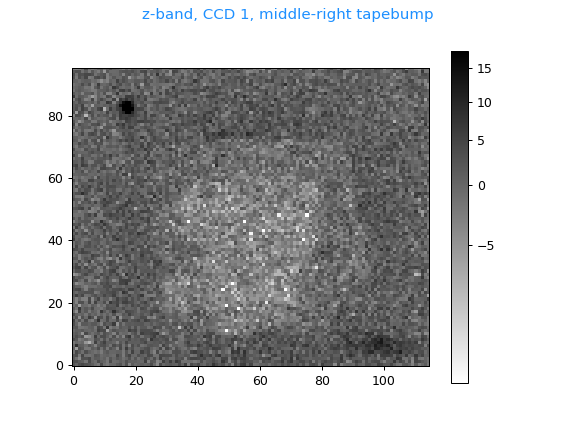

/Users/fco/anaconda3/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/fco/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


In [52]:
path_list = sel_z_path
anim_interval = 200
anim_repeat = False
anim_save = True
outfnm = 'z_tapebump_c01.mp4'
#
fig = plt.figure()
ims = []
for i in path_list:
    aux_x = np.load(i)
    # Normalize image, using astropy zscale for range, and square root for 
    # stretching (?)
    im_norm = ImageNormalize(aux_x, 
                             interval=ZScaleInterval(),
                             stretch=SqrtStretch())
    # Append each of the plots to a list
    kw  = {
        'origin' : 'lower', 
        'animated' : True, 
        'cmap' : 'gray_r',
    }
    im = plt.imshow(aux_x, norm=im_norm, **kw)
    ims.append([im])
# Using the plot-populated list, create the animation
# blitting (True/False) useful when the frame can be slightly modified to 
# create the next frame
ani = animation.ArtistAnimation(fig, ims, 
                                interval=anim_interval, 
                                blit=True,
                                repeat_delay=1000, 
                                repeat=anim_repeat)
plt.suptitle('z-band, CCD 1, middle-right tapebump', color='dodgerblue')
plt.colorbar()
if anim_save:
    if (outfnm is None):
        outfnm = 'pid{0}.mp4'.format(os.getpid())
    # Set up formatting for the movie files
    aux_wr1 = animation.writers['ffmpeg']
    aux_writer = aux_wr1(fps=5, metadata=dict(artist='F Paz-Chinchon'), bitrate=2000)
    ani.save(outfnm, writer=aux_writer)
    plt.show()
else:
    plt.show()

<IPython.core.display.Javascript object>


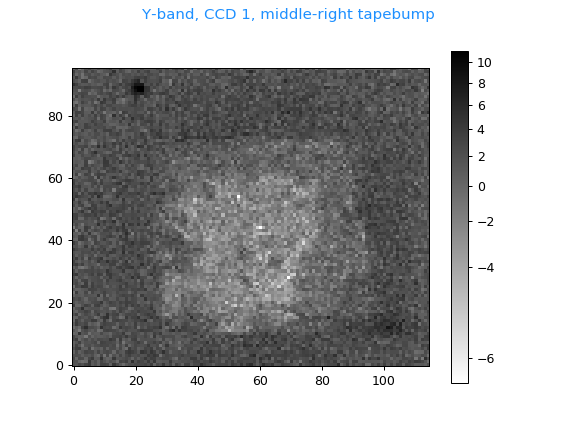

/Users/fco/anaconda3/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/fco/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


In [53]:
path_list = sel_Y_path
anim_interval = 200
anim_repeat = False
anim_save = True
outfnm = 'Y_tapebump_c01.mp4'
#
fig = plt.figure()
ims = []
for i in path_list:
    aux_x = np.load(i)
    # Normalize image, using astropy zscale for range, and square root for 
    # stretching (?)
    im_norm = ImageNormalize(aux_x, 
                             interval=ZScaleInterval(),
                             stretch=SqrtStretch())
    # Append each of the plots to a list
    kw  = {
        'origin' : 'lower', 
        'animated' : True, 
        'cmap' : 'gray_r',
    }
    im = plt.imshow(aux_x, norm=im_norm, **kw)
    ims.append([im])
# Using the plot-populated list, create the animation
# blitting (True/False) useful when the frame can be slightly modified to 
# create the next frame
ani = animation.ArtistAnimation(fig, ims, 
                                interval=anim_interval, 
                                blit=True,
                                repeat_delay=1000, 
                                repeat=anim_repeat)
plt.suptitle('Y-band, CCD 1, middle-right tapebump', color='dodgerblue')
plt.colorbar()
if anim_save:
    if (outfnm is None):
        outfnm = 'pid{0}.mp4'.format(os.getpid())
    # Set up formatting for the movie files
    aux_wr1 = animation.writers['ffmpeg']
    aux_writer = aux_wr1(fps=5, metadata=dict(artist='F Paz-Chinchon'), bitrate=2000)
    ani.save(outfnm, writer=aux_writer)
    plt.show()
else:
    plt.show()

In [ ]:


'''
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize, ZScaleInterval)

# Generate a test image
image = np.arange(65536).reshape((256, 256))

# Create an ImageNormalize object
norm = ImageNormalize(image, interval=MinMaxInterval(),
                      stretch=SqrtStretch())

# or equivalently using positional arguments
# norm = ImageNormalize(image, MinMaxInterval(), SqrtStretch())

# Display the image
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(image, origin='lower', norm=norm)
fig.colorbar(im)
'''

fig = plt.figure()
ims = []
#self.canvas.show() # insert this line
#self.canvas.get_tk_widget().update_idletasks()
for i in sel_g_path:
    aux_x = np.load(i)
    # Normalize image
    im_norm = ImageNormalize(aux_x, interval=ZScaleInterval(),
                             stretch=SqrtStretch())
    im = plt.imshow(aux_x, norm=im_norm, origin='lower', animated=True, cmap='gray_r')
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=1000, repeat=False)
# To save the animation, use e.g.
# ani.save("movie.mp4")
# or
# from matplotlib.animation import FFMpegWriter
# writer = FFMpegWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)
plt.show()

